# Previously, on WHAT THE FUCK
In:
- `2022-06-28-injection-and-recovery.ipynb` 
- `2022-06-28-injection-and-recovery-part2.ipynb` 

We used a fuck-tonne of simulations to do an injection and recovery test. It failed, except for primary mass.

We learned:
- Can make do with (bp - rp, M_G) instead of (M_bp, M_rp, M_G)
- Can make do with 10,000 simulations.
- Things did not improve if we used (M1, M2) parameterisation instead of (M1, q) -- as expected, but good to test. 

Now we're going to try:
- limit it to 4 Gyr
- limit to q > 0.5
- limit bounds, basically. see if we get better behaviour

In [1]:
import torch
from sbi import utils
from sbi import analysis
from sbi.inference.base import infer


# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial#:~:text=when%20using%20matplotlib%3A-,Error%20%2315%3A%20Initializing%20libiomp5.,performance%20or%20cause%20incorrect%20results.
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


/Users/arc/anaconda3/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("isochrone_grid.pkl", "rb") as fp:
    data = pickle.load(fp)
    
isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs, [isochrone_bs, isochrone_gs, isochrone_rs] = data
isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs = list(map(np.array, (isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs)))
isochrone_bs, isochrone_gs, isochrone_rs = list(map(np.array, [isochrone_bs, isochrone_gs, isochrone_rs]))

Text(0, 0.5, 'Age')

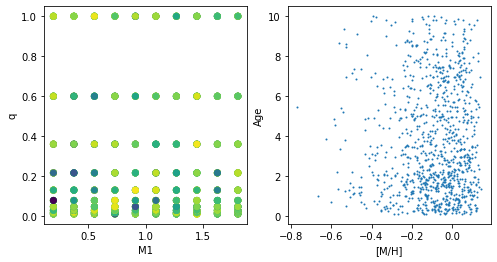

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(
    isochrone_m1s, 
    isochrone_qs,
    c=isochrone_fehs
)
axes[0].set_xlabel("M1")
axes[0].set_ylabel("q")
axes[1].scatter(
    isochrone_fehs,
    isochrone_ages,
    s=1,
)
axes[1].set_xlabel("[M/H]")
axes[1].set_ylabel("Age")

In [4]:
import torch
import numpy as np
from isochrones import get_ichrone

tracks = get_ichrone('mist', tracks=True)

def binary_color_mag_isochrones(
    m1,  # [Solar mass]
    q,   # m2/m1
    age, # [Gyr] 
    fe_h
):
    properties = tracks.generate_binary(
        m1,
        q * m1, 
        np.log10(age) + 9,  
        fe_h,
        bands=["G", "BP", "RP"]
    )
    b_mag = properties.BP_mag.values
    g_mag = properties.G_mag.values
    r_mag = properties.RP_mag.values
    #return np.array([b_mag, g_mag, r_mag]).T[0]
    return np.array([b_mag - r_mag, g_mag]).T[0]


Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [15]:

# Following https://www.mackelab.org/sbi/tutorial/00_getting_started/

print(f"Setting prior")
method = "SNPE"
labels = ("M1", "q", "age", "[M/H]")
bounds = torch.tensor([
    [0.1,  1.8], # M1
    [0.5,    1], # q
    [1,      4], # age (Gyr)
    [-0.5, 0.5]  # metallicity
])
photometric_uncertainty_scale = 1e-4

num_simulations = 10_000

prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])

print(f"Emulating posterior")
def simulator(theta):
    z = torch.tensor(binary_color_mag_isochrones(*theta))
    return z + torch.randn(z.shape) * photometric_uncertainty_scale

Setting prior
Emulating posterior


In [16]:
posterior = infer(
    simulator, 
    prior, 
    method=method, 
    num_simulations=num_simulations,
    num_workers=4
)

Running 10000 simulations in 10000 batches.:   0%|                                                    | 0/10000 [00:00<?, ?it/s]Holoviews not imported. Some visualizations will not be available.
Holoviews not imported. Some visualizations will not be available.
Holoviews not imported. Some visualizations will not be available.
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.
PyMultiNest not imported.  MultiNest fits will not work.
PyMultiNest not imported.  MultiNest fits will not work.
PyMultiNest not imported.  MultiNest fits will not work.
Running 10000 simulations in 10000 batches.: 100%|███████████████████████████████████████| 10000/10000 [00:41<00:00, 242.12it/s]


 Neural network successfully converged after 263 epochs.

In [20]:
num_samples = 10_000
num_tests = len(isochrone_m1s)
num_parameters = len(labels)
percentiles = [16, 50, 84]

all_samples = np.nan * np.ones((num_tests, num_samples, num_parameters))
all_percentiles = np.nan * np.ones((num_tests, num_parameters, len(percentiles)))
all_truths = np.vstack([isochrone_m1s, isochrone_qs, isochrone_ages, isochrone_fehs]).T
all_observations = np.vstack([isochrone_bs - isochrone_rs, isochrone_gs]).T

print(all_samples.shape)
print(all_percentiles.shape)
print(all_truths.shape)
print(all_observations.shape)

(1000, 10000, 4)
(1000, 4, 3)
(1000, 4)
(1000, 2)


In [21]:
#np.diff(all_percentiles[0, :], axis=1)

In [22]:
from tqdm import tqdm

lower, upper = np.array(bounds).T
for i, observation in enumerate(tqdm(all_observations)):    
    if not np.all(np.isfinite(observation)):
        continue
    
    # since we adjusted our prior density bounds, ignore anything outside this
    if not (np.all(upper >= all_truths[i]) and np.all(all_truths[i] >= lower)):
        continue
    
    samples = posterior.sample(
        (num_samples,), 
        x=torch.tensor(observation),
        show_progress_bars=False
    )
    all_samples[i] = np.array(samples)
    all_percentiles[i] = np.percentile(samples, percentiles, axis=0).T


100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.83it/s]


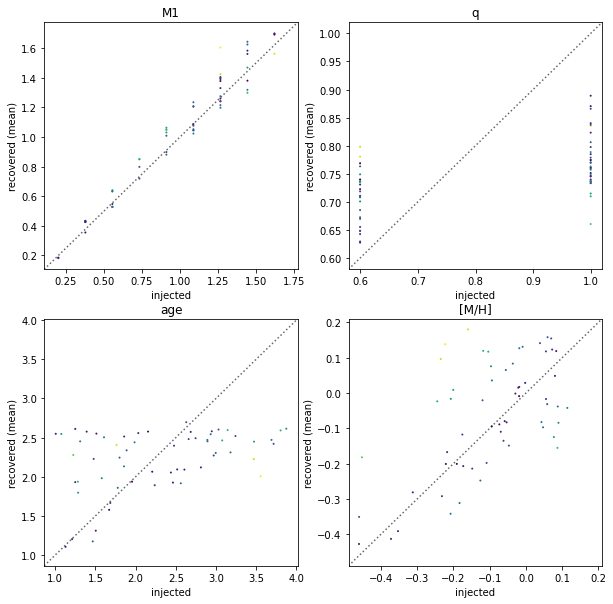

In [23]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
color_index = 3
for i, ax in enumerate(axes.flat):
    ax.scatter(
        all_truths[:, i],
        all_percentiles[:, i, 1],
        s=1,
        c=np.abs(all_truths[:, color_index] - all_percentiles[:, color_index, 1])
    )
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", zorder=-1, ls=":")
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_title(labels[i])
    ax.set_xlabel(r"injected")
    ax.set_ylabel(r"recovered (mean)")

# WTF

OK, let's try with JUST solar metallicity stuff...

In [24]:
def solar_metallicity_binary(
    m1,  # [Solar mass]
    q,   # m2/m1
    age, # [Gyr] 
):
    properties = tracks.generate_binary(
        m1,
        q * m1, 
        np.log10(age) + 9,  
        0,
        bands=["G", "BP", "RP"]
    )
    b_mag = properties.BP_mag.values
    g_mag = properties.G_mag.values
    r_mag = properties.RP_mag.values
    #return np.array([b_mag, g_mag, r_mag]).T[0]
    return np.array([b_mag - r_mag, g_mag]).T[0]


In [27]:

# Following https://www.mackelab.org/sbi/tutorial/00_getting_started/

print(f"Setting prior")
method = "SNPE"
labels = ("M1", "q", "age")
bounds = torch.tensor([
    [0.1,  1.8], # M1
    [0.5,    1], # q
    [1,      4], # age (Gyr)
#    [-0.5, 0.5]  # metallicity
])
photometric_uncertainty_scale = 1e-4

num_simulations = 10_000

prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])

print(f"Emulating posterior")
def simulator(theta):
    z = torch.tensor(solar_metallicity_binary(*theta))
    return z + torch.randn(z.shape) * photometric_uncertainty_scale

Setting prior
Emulating posterior


In [28]:
posterior = infer(
    simulator, 
    prior, 
    method=method, 
    num_simulations=num_simulations,
    num_workers=4
)

Running 10000 simulations in 10000 batches.:   0%|                                                    | 0/10000 [00:00<?, ?it/s]Holoviews not imported. Some visualizations will not be available.
Holoviews not imported. Some visualizations will not be available.
Holoviews not imported. Some visualizations will not be available.
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.
PyMultiNest not imported.  MultiNest fits will not work.
PyMultiNest not imported.  MultiNest fits will not work.
PyMultiNest not imported.  MultiNest fits will not work.
Running 10000 simulations in 10000 batches.: 100%|███████████████████████████████████████| 10000/10000 [00:36<00:00, 274.11it/s]


 Neural network successfully converged after 200 epochs.

In [54]:
Z = 10
all_obs = []
all_truths = []
for q in np.linspace(*bounds[0], Z):
    for m1 in np.linspace(*bounds[1], Z):
        for age in np.linspace(*bounds[2], Z):
            all_truths.append((q, m1, age))
            all_obs.append(solar_metallicity_binary(*all_truths[-1]))

In [55]:
all_obs = np.array(all_obs)
all_truths = np.array(all_truths)

In [69]:
from tqdm import tqdm

num_samples = 30
num_tests = len(all_obs)
num_parameters = len(labels)

all_samples = np.nan * np.ones((num_tests, num_samples, num_parameters))
all_medians = np.nan * np.ones((num_tests, num_parameters))

print(all_samples.shape)
print(all_percentiles.shape)

for i, observation in enumerate(tqdm(all_obs)):    
    if not np.all(np.isfinite(observation)):
        continue
        
    samples = posterior.sample(
        (num_samples,), 
        x=torch.tensor(observation),
        show_progress_bars=False
    )
    all_samples[i] = np.array(samples)
    all_medians[i] = np.std(np.array(samples), axis=0)
    #print(all_truths[i], all_percentiles[i, :, 1])

(1000, 30, 3)
(1000, 3, 3)


 96%|███████████████████████████████████████████████████████████████████████████████████▌   | 961/1000 [00:07<00:00, 250.15it/s]WARNING:root:Only 1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining -21 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.
100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.20it/s]


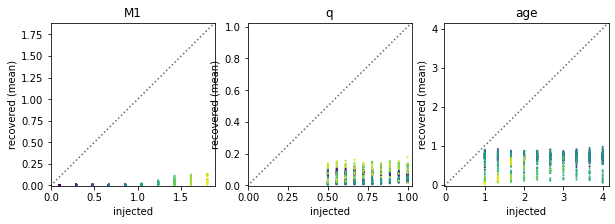

In [70]:
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
color_index = 0
for i, ax in enumerate(axes.flat):
    ax.scatter(
        all_truths[:, i],
        all_medians[:, i],
        s=1,
        c=np.abs(all_truths[:, color_index] - all_medians[:, color_index])
    )
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", zorder=-1, ls=":")
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_title(labels[i])
    ax.set_xlabel(r"injected")
    ax.set_ylabel(r"recovered (mean)")

array([1.5745192, 0.7391112, 2.4310956], dtype=float32)